In [1]:
import os
os.chdir("..")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
data_dir = Path("data")
files = sorted(data_dir.glob("data-*.parquet"))

df_list = []
for file in files:
    df_list.append(pd.read_parquet(file)[["delay_in_min", "station_name", "is_canceled", "train_type"]])
df = pd.concat(df_list, ignore_index=True)

print(f"Loaded {len(df):,} records from {len(files)} files")
print(f"Files: {[f.name for f in files]}")

Loaded 31,396,208 records from 3 files
Files: ['data-2025-10.parquet', 'data-2025-11.parquet', 'data-2025-12.parquet']


In [19]:
# Calculate statistics for each train type
train_types = ["Alle", "ICE", "IC", "RE", "RB", "S"]
stats = {}

for train_type in train_types:
    if train_type == "Alle":
        df_filtered = df
        type_label = "Trainstop"
    else:
        df_filtered = df[df["train_type"] == train_type]
        type_label = f"{train_type}-Trainstop"

    canceled_rate = df_filtered["is_canceled"].mean() * 100
    df_not_canceled = df_filtered[~df_filtered["is_canceled"]]

    total_stops = len(df_not_canceled)
    mean_delay = df_not_canceled["delay_in_min"].mean()
    punctual_rate = (df_not_canceled["delay_in_min"] < 6).mean() * 100

    stats[train_type] = {
        "total_stops": total_stops,
        "mean_delay": f"{int(mean_delay)}:{int((mean_delay % 1) * 60):02d}",
        "punctual_rate": f"{punctual_rate:.0f}%",
        "canceled_rate": f"{canceled_rate:.0f}%",
    }

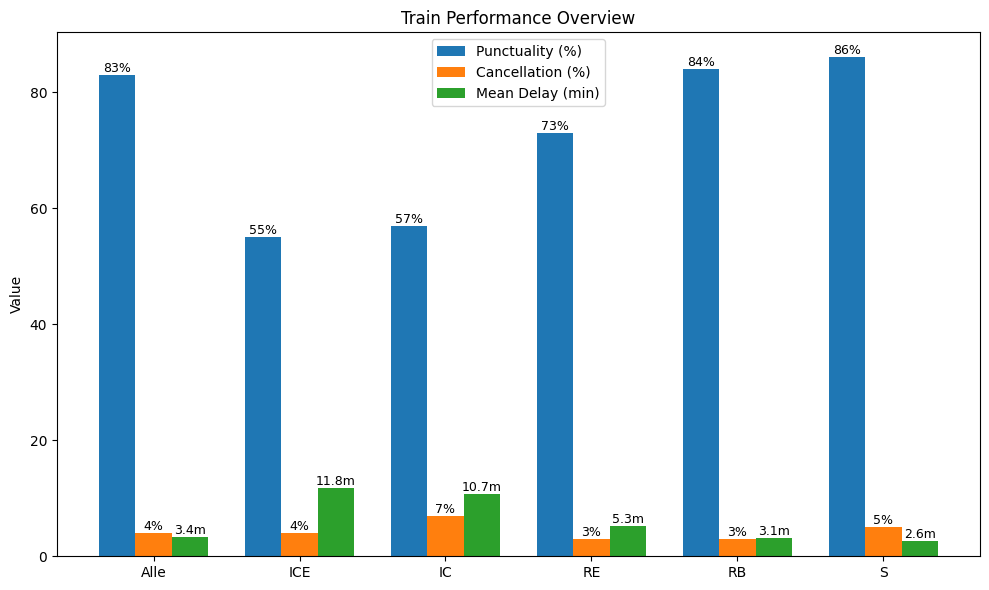

In [24]:
df = pd.DataFrame(stats).T

# ---------------------------
# Preprocessing
# ---------------------------
df['punctual_rate'] = df['punctual_rate'].str.rstrip('%').astype(int)
df['canceled_rate'] = df['canceled_rate'].str.rstrip('%').astype(int)

def delay_to_minutes(x):
    m, s = x.split(':')
    return int(m) + int(s)/60

df['mean_delay_min'] = df['mean_delay'].apply(delay_to_minutes)

# ---------------------------
# Single Combined Plot
# ---------------------------
x = np.arange(len(df))
width = 0.25

plt.figure(figsize=(10,6))

bars1 = plt.bar(x - width, df['punctual_rate'], width, label='Punctuality (%)')
bars2 = plt.bar(x, df['canceled_rate'], width, label='Cancellation (%)')
bars3 = plt.bar(x + width, df['mean_delay_min'], width, label='Mean Delay (min)')

plt.xticks(x, df.index)
plt.ylabel('Value')
plt.title('Train Performance Overview')
plt.legend()
plt.tight_layout()

# ---------------------------
# Add value labels
# ---------------------------
def add_labels(bars, suffix=''):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.1f}{suffix}' if isinstance(height, float) else f'{height}{suffix}',
            ha='center',
            va='bottom',
            fontsize=9
        )

add_labels(bars1, '%')
add_labels(bars2, '%')
add_labels(bars3, 'm')

plt.show()